In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

### What's different between the flat scaling in gen2/gen3?
* Gen3 allows things to be split cleanly into separate tasks.
  * `IsrTask` runs as normal on separate {instrument, exposure, detector} images
  * `CpFlatMeasureTask` applies vignetting and measure detector/amplifier level statistics on those ISR processed images
  * `CpFlatNormalizationTask` collects all statistics for all inputs and calculates scaling factors.
  * `CalibCombineTask` takes the scales and ISR processed images, scales the image, and then combines them appropriately to produce the proposed flat.
* Hopefully this results in less confusion for everyone (especially me).
* Pixel level differences:
  * ISR processed images are identical, except for HSC detector 9, which is mysteriously not fully masked by defects in gen2.  I have ignored this issue as out-of-scope, after confirming that the scales calculated do not significantly change.
  * Detector level statistics are different, as we now exclude the vignetted region.
  * Scale calculation is different, as where ever possible, `np.mean(data)` is replaced with `np.average(data, weights)`, using the pixel counts used to measure the statistic being averaged.  This ensures that fully illuminated detectors contribute more than mostly vignetted.
  * Combine now excludes the finalScale operation.
* Scaling differences:
  * The measured background levels from the set of nExp exposures containing nChip detectors are put into a matrix `B[nExp, nChip]` that we want to decompose into an exposure level flux correction `E[nExp]` and a detector level gain+vignetting scale `G[nChip]`.
  * `B` should be the Hadamard product of `E` and `G` after appropriately broadcasting these vectors into matrices of size `(nExp, nChip)`.  This is solved iteratively using the `constructCalibs.py`/PanSTARRS algorithm.
  * The elements of `E` contain the scale factors applied to all input images prior to combination.
  * The elements of `G` contain the scale factors that were previously applied to each output combined flat, such that `final = combined * G[detId] / <combined>`.  In gen2, `G[detId]` and `<combined>` were essentially identical, making this unnecessary.  I believe this makes sense mathematically, and so although `G` is needed to find `E`, it is no longer used for final scaling.

### Statistics presented below:
  * Final output images had statistics measured for the image plane, excluding NAN pixels.
  * Gen2 and Gen3 means and stddev are linear, except when vignetting occurs.
  * Gen3 is 8% lower than Gen2, which will result in processed images with 8% larger counts.
  * Deviations track exactly well with fraction of non-nan pixels used (based on Gen3 images).

In [2]:
gen2 = pd.read_csv("/tmp/0527.gen2.imstats", sep='\s+', comment='#', header=None,
                   names=['mean','std','median','qsig','min','q25','q75','max','count','xdim', 'ydim'])
gen3 = pd.read_csv("/tmp/0527.gen3.imstats", sep='\s+', comment='#', header=None,
                    names=['mean','std','median','qsig','min','q25','q75','max','count','xdim', 'ydim'])

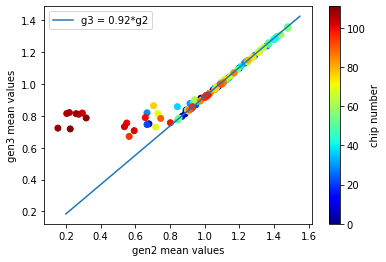

In [3]:
statistic = 'mean'
pp = plt.scatter(gen2[statistic], gen3[statistic], c=range(0, 112, 1), cmap='jet')
plt.plot(np.arange(0.2, 1.6, 0.05), 0.92 * np.arange(0.2, 1.6, 0.05), label="g3 = 0.92*g2")
plt.xlabel(f"gen2 {statistic} values")
plt.ylabel(f"gen3 {statistic} values")
plt.legend()
cbar = plt.colorbar(pp)
cbar.set_label("chip number")

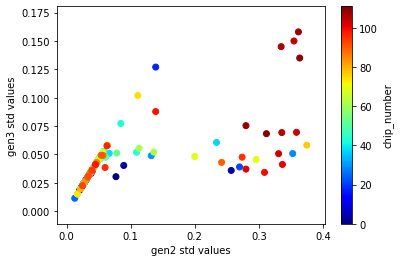

In [4]:
statistic = 'std'
pp = plt.scatter(gen2[statistic], gen3[statistic], c=range(0, 112, 1), cmap='jet')
plt.xlabel(f"gen2 {statistic} values")
plt.ylabel(f"gen3 {statistic} values")
#plt.legend()
cbar = plt.colorbar(pp)
cbar.set_label('chip_number')

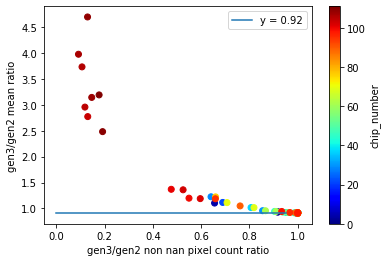

In [5]:
pp = plt.scatter(gen3['count'] / gen2['count'], gen3['mean'] / gen2['mean'],
                 c=range(0, 112, 1), cmap='jet')
plt.plot(np.arange(0,  1.0, 0.05), [0.92] * 20, label="y = 0.92")
plt.xlabel("gen3/gen2 non nan pixel count ratio")
plt.ylabel("gen3/gen2 mean ratio")
plt.legend()
cbar = plt.colorbar(pp)
cbar.set_label('chip_number')

### Apply flat to inputs and look at residuals.
 * Nothing very clear from detector level statistics.
 * Focal plane images and cuts show small tilts that are likely caused by lamp changes.
 * Residuals seem plausible (by eye peak-to-peak difference in cuts [+25, -100, +50, +50, -25]).

In [6]:
applied = pd.read_csv("/tmp/0527.applied.imstats", sep='\s+', comment='#')

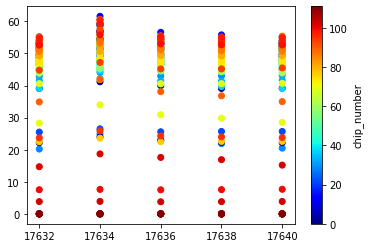

In [7]:
pp = plt.scatter(applied['expId'],
                 applied['qsig'], c=applied['detId'], cmap='jet')
cbar = plt.colorbar(pp)
cbar.set_label('chip_number')

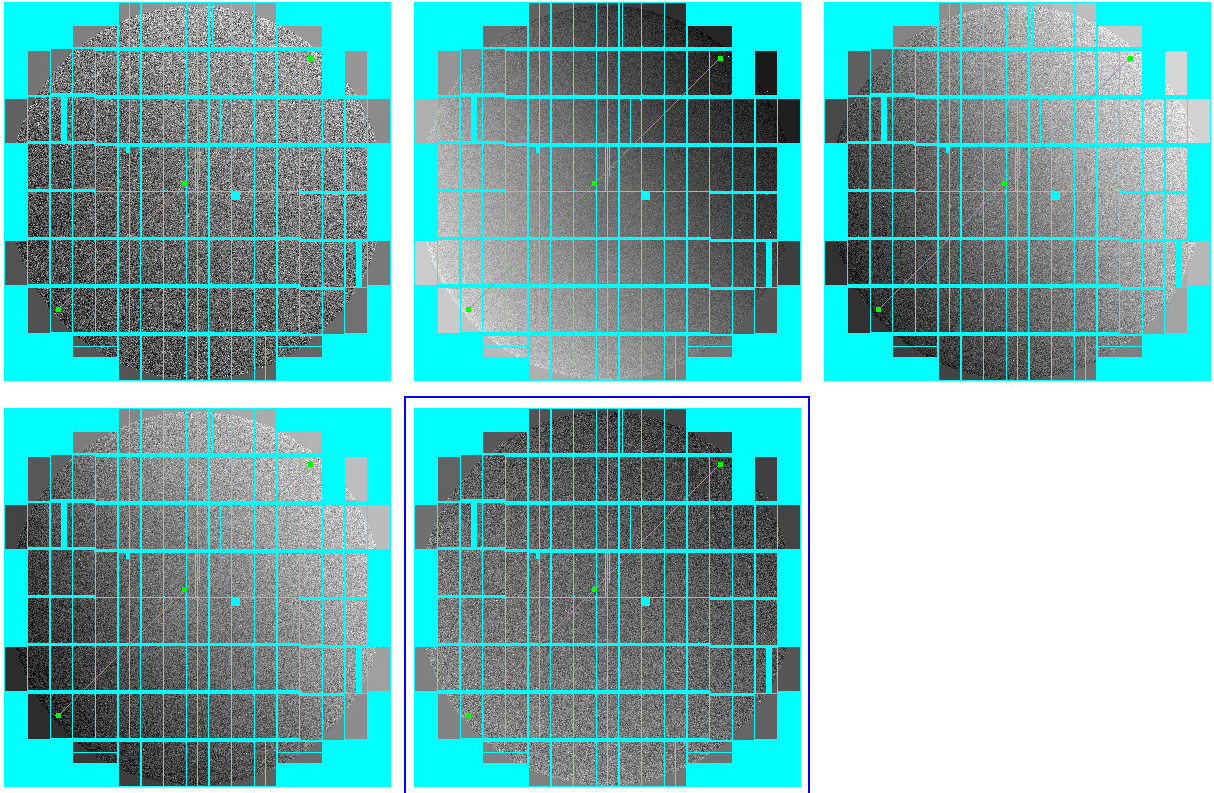

In [8]:
Image(filename="/tmp/ISR_FP_inputs.jpg")

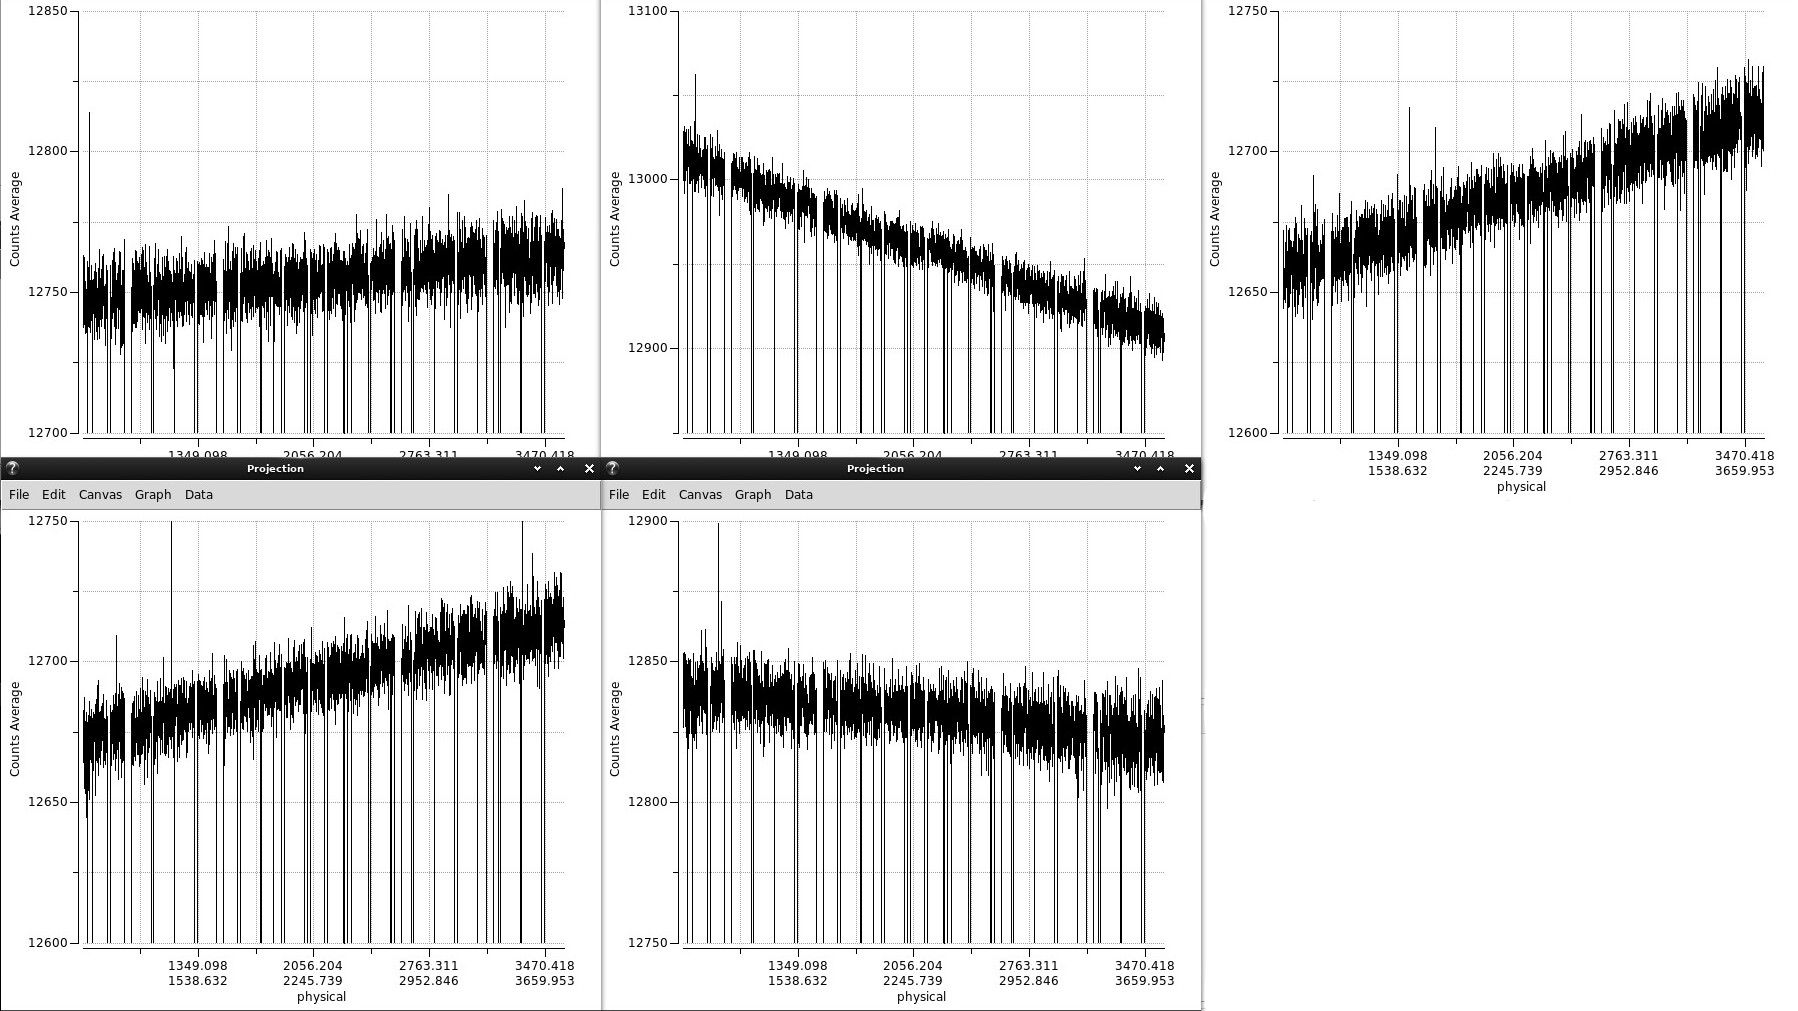

In [9]:
Image(filename="/tmp/ISR_FP_cuts.jpg")